In [1063]:
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from load_tichu_data import *
from util import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1391]:
plt.rcParams.update({'font.size': 22})

# Turn the hand into playable patterns.
evaluate it in a way that a human player would parse the data.

In [654]:
#matches0 = load_sql_insert_file_data('data/onlinetichu_gamedata_1106.sql')
matches1 = load_sql_insert_file_data('data/onlinetichu_gamedata_1209/onlinetichu_gamedata_572_to_5024.sql')
matches2 = load_sql_insert_file_data('data/onlinetichu_gamedata_1209/onlinetichu_gamedata_5025_to_7788.sql')
matches3 = load_sql_insert_file_data('data/onlinetichu_gamedata_1209/onlinetichu_gamedata_7788_to_15366.sql')
matches =  matches1 + matches2 + matches3

In [1649]:
len(matches)

14765

## plotting scripts

In [1423]:
def plot_model(model, name, maintitle=[]):
    logit_roc_auc = roc_auc_score(testy, model.predict_proba(testX)[:,1])
    fpr, tpr, thresholds = roc_curve(testy, model.predict_proba(testX)[:,1])
    plt.plot(fpr, tpr, label='{:s} (area = {:0.3f})'.format(name, logit_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if maintitle == []:
        plt.title('Receiver operating characteristic on validation set')
    else:
        plt.title(maintitle)
    plt.legend(loc="lower right")
def plot_training(model, name, maintitle=[]):
    logit_roc_auc = roc_auc_score(trainy, model.predict_proba(trainX)[:,1])
    fpr, tpr, thresholds = roc_curve(trainy, model.predict_proba(trainX)[:,1])
    plt.plot(fpr, tpr, label='{:s} (area = {:0.3f})'.format(name, logit_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if maintitle == []:
        plt.title('Receiver operating characteristic on training set')
    else:
        plt.title(maintitle)
    plt.legend(loc="lower right")
def plot_data(model, name, trainX, trainy, maintitle = []):
    logit_roc_auc = roc_auc_score(trainy, model.predict_proba(trainX)[:,1])
    fpr, tpr, thresholds = roc_curve(trainy, model.predict_proba(trainX)[:,1])
    plt.plot(fpr, tpr, label='{:s} (area = {:0.3f})'.format(name, logit_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if maintitle == []:
        plt.title('Receiver operating characteristic on training set')
    else:
        plt.title(maintitle)
    plt.legend(loc="lower right")

# Run classification algorithms on the feature vector instead
## create feature vector as X

In [1065]:
tichudata = tichuDataExtend()
tichudata.loaddata(matches)
n = len(tichudata.made)
print n

85972


In [852]:
sum(tichudata.made)/float(n)

0.42986088493928254

In [1128]:
gdata = grandData()
gdata.loaddata(matches)
n = len(gdata.made)
print n

20484


In [1129]:
sum(gdata.made)/float(n)

0.6639328256199961

# With the compressed hand. 
### num of cards in each number, dog, phoenix, dragon, straight flush

In [715]:
[train_ind, test_ind] = train_test_split(range(len(tichudata.made)),random_state=2)
trainX = tichudata.compress_hand[train_ind]
trainy = tichudata.made[train_ind]
testX = tichudata.compress_hand[test_ind]
testy = tichudata.made[test_ind]

In [720]:
lr = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', \
                        multi_class='ovr').fit(trainX, trainy)
lr.fit(trainX, trainy)
mnb = MultinomialNB()
mnb.fit(abs(trainX), trainy)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [717]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),
                         algorithm="SAMME",
                         n_estimators=300)
bdt.fit(trainX, trainy);

In [718]:
#rf = RandomForestClassifier(n_estimators=100, max_features=10,  max_depth=5, class_weight='balanced')
rf = RandomForestClassifier(n_estimators=100, max_features=6,  max_depth=10)
rf.fit(trainX, trainy);

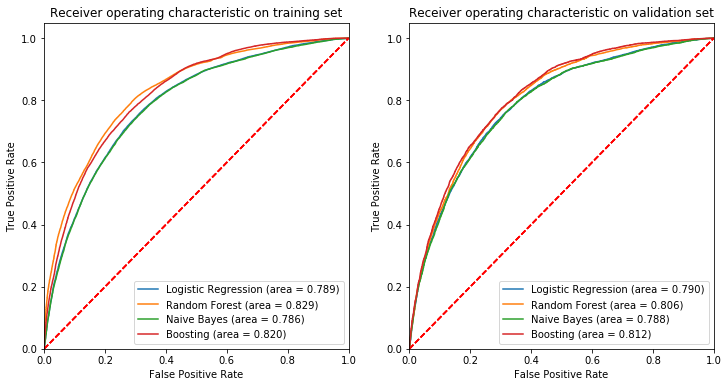

In [723]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_training(lr,'Logistic Regression')
plot_training(rf,'Random Forest')
plot_training(mnb,'Naive Bayes')
plot_training(bdt,'Boosting')
plt.subplot(1,2,2)
plot_model(lr,'Logistic Regression')
plot_model(rf,'Random Forest')
plot_model(mnb,'Naive Bayes')
plot_model(bdt,'Boosting')

In [489]:
explanation = np.concatenate((range(1,15),['dog','dragon','phoenix','num_of_straight_flushes']))
np.transpose([explanation,lr.coef_[0]])

array([['1', '-0.011095167849774714'],
       ['2', '-0.16731869135701904'],
       ['3', '-0.16143431645720527'],
       ['4', '-0.14929424008453293'],
       ['5', '-0.12828013557280368'],
       ['6', '-0.1370030331044192'],
       ['7', '-0.16809990423822163'],
       ['8', '-0.13702786138756304'],
       ['9', '-0.11117077473890215'],
       ['10', '-0.12827173912626064'],
       ['11', '-0.14747644007533237'],
       ['12', '-0.04913661242693283'],
       ['13', '-0.013879034570712458'],
       ['14', '0.4000975620859453'],
       ['dog', '-0.7441376533561983'],
       ['dragon', '1.5086548426045734'],
       ['phoenix', '1.2872746087802214'],
       ['num_of_straight_flushes', '1.1174249613169402']], dtype='|S32')

## With just the feature vector

In [1451]:
tichudata.feature_explanation

['self.ace',
 'self.dog',
 'self.dragon',
 'self.phoenix',
 'self.num_of_bombs',
 'self.num_of_threes',
 'self.largest_three',
 'self.num_of_pairs',
 'self.largest_pair',
 'self.longest_straight_length',
 'self.largest_straight',
 'self.num_of_tractors',
 'self.num_small_card']

In [1452]:
[train_ind, test_ind] = train_test_split(range(len(tichudata.made)),random_state=2)
selectfeature = [0,1,2,3,4,9,12]
trainX = tichudata.feature_vector[train_ind]
trainX[:,9] = trainX[:,9] > 0
trainX = trainX[:,selectfeature]

trainy = tichudata.made[train_ind]
testX = tichudata.feature_vector[test_ind]
testX[:,9] = testX[:,9] > 0
testX = testX[:,selectfeature]
testy = tichudata.made[test_ind]

In [1453]:
lr = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', \
                        multi_class='ovr').fit(trainX, trainy)
lr.fit(trainX, trainy)
mnb = MultinomialNB()
mnb.fit(abs(trainX), trainy);

In [1454]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6,class_weight='balanced'),
                         algorithm="SAMME",
                         n_estimators=100)
bdt.fit(trainX, trainy);

In [1455]:
rf = RandomForestClassifier(n_estimators=100, max_features=6,  max_depth=8, class_weight='balanced')
rf.fit(trainX, trainy);

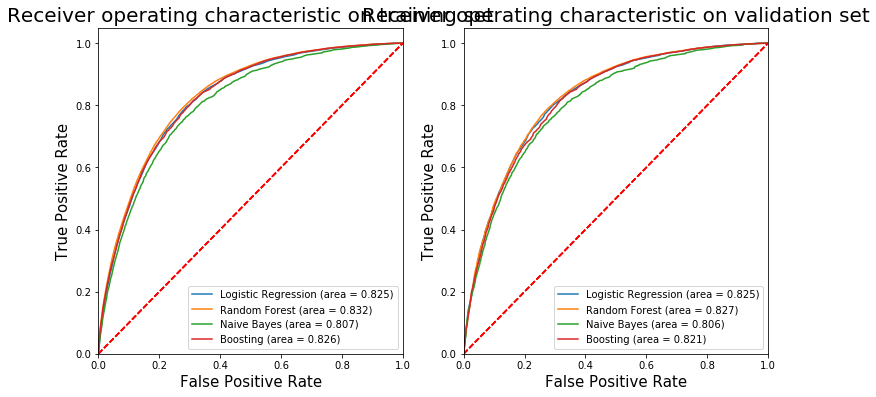

In [1456]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_training(lr,'Logistic Regression')
plot_training(rf,'Random Forest')
plot_training(mnb,'Naive Bayes')
plot_training(bdt,'Boosting')
plt.subplot(1,2,2)
plot_model(lr,'Logistic Regression')
plot_model(rf,'Random Forest')
plot_model(mnb,'Naive Bayes')
plot_model(bdt,'Boosting')

In [1457]:
explanation = np.array(tichudata.feature_explanation)[selectfeature]
coeff = copy.deepcopy(lr.coef_[0])
coeff[5] = coeff[5]
np.transpose([explanation,coeff*3.5])

array([['self.ace', '2.0672561744843962'],
       ['self.dog', '-1.9756784139469754'],
       ['self.dragon', '6.048001906699842'],
       ['self.phoenix', '5.858824353386394'],
       ['self.num_of_bombs', '4.835316915247606'],
       ['self.longest_straight_length', '1.072029394052266'],
       ['self.num_small_card', '-1.1816075852843493']], dtype='|S32')

In [1458]:
def reduce_to_index(fv):
    selectfeature = [0,1,2,3,4,9,12]
    temp = copy.deepcopy(fv)
    # just want whether there are straights or not
    temp[9] = temp[9] > 0
    temp = temp[selectfeature]
    w = np.array([2,-2,6,6,5,1,-1],float)
    return np.array([1,sum(w*temp)])

In [650]:
[train_ind, test_ind] = train_test_split(range(len(tichudata.made)),random_state=2)

trainX = np.array([reduce_to_index(fv) for fv in tichudata.feature_vector[train_ind]])
trainy = tichudata.made[train_ind]
testX = np.array([reduce_to_index(fv) for fv in tichudata.feature_vector[test_ind]])
testy = tichudata.made[test_ind]

In [651]:
lr = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', \
                        multi_class='ovr').fit(trainX, trainy)
lr.fit(trainX, trainy)
mnb = MultinomialNB()
mnb.fit(abs(trainX), trainy);

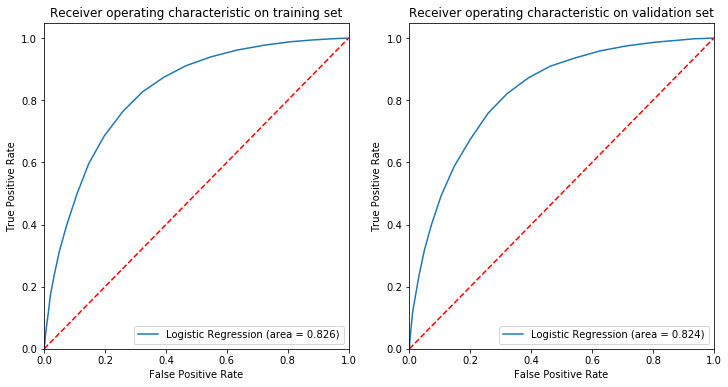

In [652]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_training(lr,'Logistic Regression')
#plot_training(mnb,'Naive Bayes')
plt.subplot(1,2,2)
plot_model(lr,'Logistic Regression')
#plot_model(mnb,'Naive Bayes')

## features plus cards as input X

In [1496]:
[train_ind, test_ind] = train_test_split(range(len(tichudata.made)),random_state=1)
trainX = tichudata.feature_vector_extend[train_ind]
trainy = tichudata.made[train_ind]
testX = tichudata.feature_vector_extend[test_ind]
testy = tichudata.made[test_ind]

In [1497]:
lr = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', \
                        multi_class='ovr').fit(trainX, trainy)
lr.fit(trainX, trainy)
mnb = MultinomialNB()
mnb.fit(abs(trainX), trainy)
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=7,class_weight='balanced'),
                         algorithm="SAMME",
                         n_estimators=100)
bdt.fit(trainX, trainy);

In [1498]:
rf = RandomForestClassifier(n_estimators=100, max_features=10,  max_depth=10, class_weight='balanced')
rf.fit(trainX, trainy);

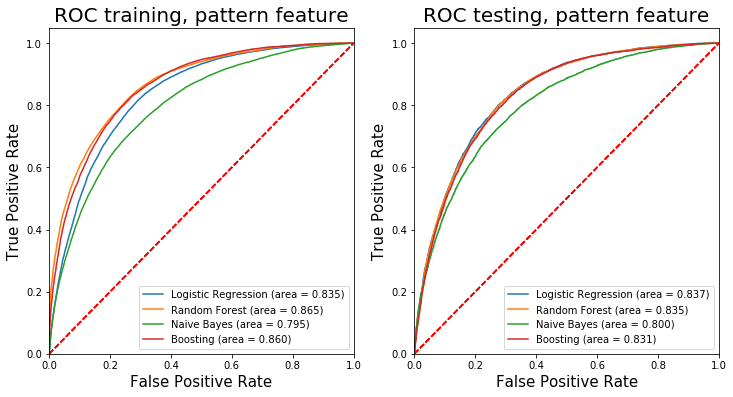

In [1499]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_training(lr,'Logistic Regression')
plot_training(rf,'Random Forest')
plot_training(mnb,'Naive Bayes')
plot_training(bdt,'Boosting', 'ROC training, pattern feature')
plt.subplot(1,2,2)
plot_model(lr,'Logistic Regression')
plot_model(rf,'Random Forest')
plot_model(mnb,'Naive Bayes')
plot_model(bdt,'Boosting', 'ROC testing, pattern feature')

In [1500]:
plt.rcParams.update({'font.size': 10})
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

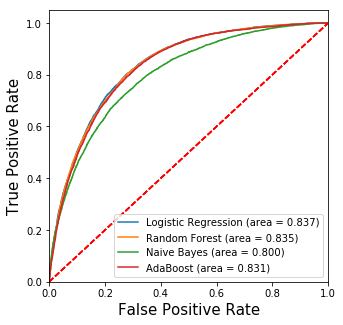

In [1501]:
plt.figure(figsize=(5,5))
plot_model(lr,'Logistic Regression')
plot_model(rf,'Random Forest')
plot_model(mnb,'Naive Bayes')
plot_model(bdt,'AdaBoost', 'ROC of Validation')
plt.title('')

# hand input only

In [298]:
[train_ind, test_ind] = train_test_split(range(len(tichudata.made)),random_state=2)
trainX = tichudata.allcards[train_ind]
trainy = tichudata.made[train_ind]
testX = tichudata.allcards[test_ind]
testy = tichudata.made[test_ind]

In [299]:
lr = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', \
                        multi_class='ovr').fit(trainX, trainy)
lr.fit(trainX, trainy)
mnb = MultinomialNB()
mnb.fit(abs(trainX), trainy)
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                         algorithm="SAMME",
                         n_estimators=200)
bdt.fit(trainX, trainy);

In [300]:
rf = RandomForestClassifier(n_estimators=100, max_features=15,  max_depth=8, class_weight='balanced')
rf.fit(trainX, trainy);

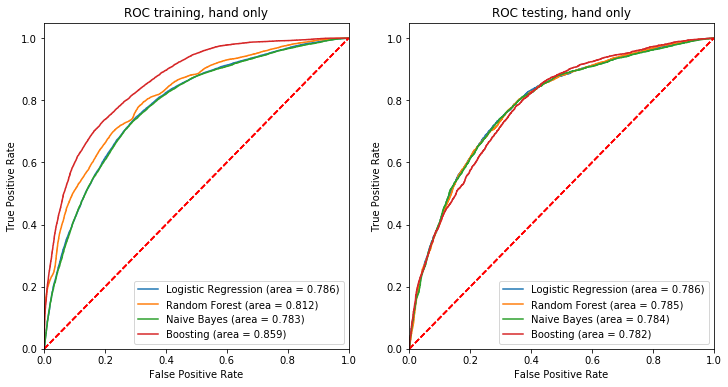

In [301]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_training(lr,'Logistic Regression')
plot_training(rf,'Random Forest')
plot_training(mnb,'Naive Bayes')
plot_training(bdt,'Boosting', 'ROC training, hand only')
plt.subplot(1,2,2)
plot_model(lr,'Logistic Regression')
plot_model(rf,'Random Forest')
plot_model(mnb,'Naive Bayes')
plot_model(bdt,'Boosting', 'ROC testing, hand only')

## Feature vector plus compress vector

In [1472]:
[train_ind, test_ind] = train_test_split(range(len(tichudata.made)),random_state=2)
allX = np.concatenate((tichudata.feature_vector, tichudata.compress_hand),1)

trainX = allX[train_ind]
trainy = tichudata.made[train_ind]
testX = allX[test_ind]
testy = tichudata.made[test_ind]

In [1473]:
lr = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', \
                        multi_class='ovr').fit(trainX, trainy)
lr.fit(trainX, trainy)
mnb = MultinomialNB()
mnb.fit(abs(trainX), trainy)
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6, class_weight='balanced'),
                         algorithm="SAMME",
                         n_estimators=50)
bdt.fit(trainX, trainy);

In [1474]:
rf = RandomForestClassifier(n_estimators=200, max_features=15,  max_depth=8, class_weight='balanced')
rf.fit(trainX, trainy);

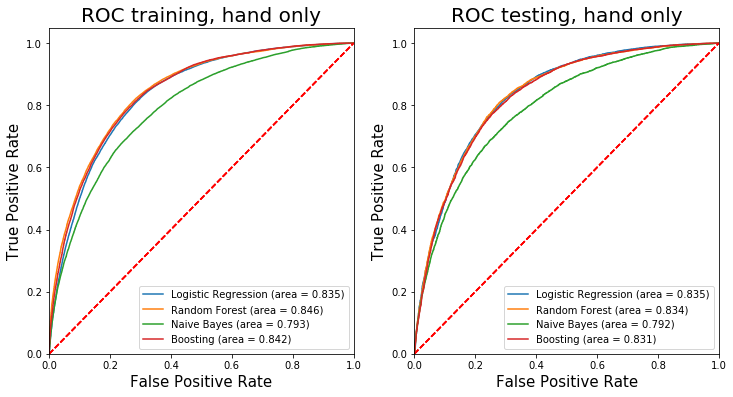

In [1475]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_training(lr,'Logistic Regression')
plot_training(rf,'Random Forest')
plot_training(mnb,'Naive Bayes')
plot_training(bdt,'Boosting', 'ROC training, hand only')
plt.subplot(1,2,2)
plot_model(lr,'Logistic Regression')
plot_model(rf,'Random Forest')
plot_model(mnb,'Naive Bayes')
plot_model(bdt,'Boosting', 'ROC testing, hand only')

In [1476]:
explanation = np.concatenate((tichudata.feature_explanation, range(1,15), ['dog','dragon','phoenix','num_of_straight_flushes']))
np.transpose([explanation, lr.coef_[0]])

array([['self.ace', '0.27581349498706653'],
       ['self.dog', '-0.3798340112621934'],
       ['self.dragon', '0.8320212941021464'],
       ['self.phoenix', '0.7900398694299371'],
       ['self.num_of_bombs', '1.4060520356960606'],
       ['self.num_of_threes', '-0.11552383547025805'],
       ['self.largest_three', '0.003028264646384668'],
       ['self.num_of_pairs', '-0.28216554969432994'],
       ['self.largest_pair', '0.01901605553165615'],
       ['self.longest_straight_length', '0.11992048582999004'],
       ['self.largest_straight', '-0.0623953289406298'],
       ['self.num_of_tractors', '0.30695865081314416'],
       ['self.num_small_card', '-0.34122399708882684'],
       ['1', '0.21506624010343695'],
       ['2', '-0.18230991452330741'],
       ['3', '-0.15948270808787648'],
       ['4', '-0.16529952984677823'],
       ['5', '-0.15196362167287117'],
       ['6', '-0.1317883452327404'],
       ['7', '-0.14590939419715754'],
       ['8', '-0.11427702701219741'],
       ['9', '-

# Feature comparison with Logistic Regression

In [1481]:
[train_ind, test_ind] = train_test_split(range(len(tichudata.made)),random_state=1)
allX = tichudata.allcards

trainX = allX[train_ind]
trainy = tichudata.made[train_ind]
testX = allX[test_ind]
testy = tichudata.made[test_ind]
stupidhand = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', \
                        multi_class='ovr').fit(trainX, trainy)
stupidhand.fit(trainX, trainy);
mnb1 = MultinomialNB()
mnb1.fit(abs(trainX), trainy)
bdt1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6, class_weight='balanced'),
                         algorithm="SAMME",
                         n_estimators=50)
bdt1.fit(trainX, trainy);
rf_sh = RandomForestClassifier(n_estimators=100, max_features=6,  max_depth=8, class_weight='balanced')
rf_sh.fit(trainX, trainy);

testX_sh = testX
testy_sh = testy

In [1482]:
[train_ind, test_ind] = train_test_split(range(len(tichudata.made)),random_state=1)
allX = tichudata.compress_hand

trainX = allX[train_ind]
trainy = tichudata.made[train_ind]
testX = allX[test_ind]
testy = tichudata.made[test_ind]
ch = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', \
                        multi_class='ovr').fit(trainX, trainy)
ch.fit(trainX, trainy);
mnb2 = MultinomialNB()
mnb2.fit(abs(trainX), trainy)
bdt2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6, class_weight='balanced'),
                         algorithm="SAMME",
                         n_estimators=50)
bdt2.fit(trainX, trainy);
rf_ch = RandomForestClassifier(n_estimators=100, max_features=6,  max_depth=8, class_weight='balanced')
rf_ch.fit(trainX, trainy);

testX_ch = testX
testy_ch = testy

In [1483]:
[train_ind, test_ind] = train_test_split(range(len(tichudata.made)),random_state=1)
allX = tichudata.feature_vector

trainX = allX[train_ind]
trainy = tichudata.made[train_ind]
testX = allX[test_ind]
testy = tichudata.made[test_ind]
fv = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', \
                        multi_class='ovr').fit(trainX, trainy)
fv.fit(trainX, trainy);
mnb3 = MultinomialNB()
mnb3.fit(abs(trainX), trainy)
bdt3 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6, class_weight='balanced'),
                         algorithm="SAMME",
                         n_estimators=50)
bdt3.fit(trainX, trainy);
rf_fv = RandomForestClassifier(n_estimators=100, max_features=6,  max_depth=8, class_weight='balanced')
rf_fv.fit(trainX, trainy);

testX_fv = testX
testy_fv = testy

In [1895]:
[train_ind, test_ind] = train_test_split(range(len(tichudata.made)),random_state=1)
allX = tichudata.ultimate

trainX = allX[train_ind]
trainy = tichudata.made[train_ind]
testX = allX[test_ind]
testy = tichudata.made[test_ind]
ult = LogisticRegression(random_state=0, solver='liblinear', \
                        multi_class='ovr').fit(trainX, trainy)
ult.fit(trainX, trainy);
mnb4 = MultinomialNB()
mnb4.fit(abs(trainX), trainy)
bdt4 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6, class_weight='balanced'),
                         algorithm="SAMME",
                         n_estimators=50)
bdt4.fit(trainX, trainy);
rf_ult = RandomForestClassifier(n_estimators=100,  max_depth=8, class_weight='balanced')
rf_ult.fit(trainX, trainy);

testX_ult = testX
testy_ult = testy

In [1485]:
[train_ind, test_ind] = train_test_split(range(len(tichudata.made)),random_state=1)
allX = tichudata.fv_plus_compress_hand

trainX = allX[train_ind]
trainy = tichudata.made[train_ind]
testX = allX[test_ind]
testy = tichudata.made[test_ind]
chpfv = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', \
                        multi_class='ovr').fit(trainX, trainy)
chpfv.fit(trainX, trainy);
mnb5 = MultinomialNB()
mnb5.fit(abs(trainX), trainy)
bdt5 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6, class_weight='balanced'),
                         algorithm="SAMME",
                         n_estimators=50)
bdt5.fit(trainX, trainy);
rf_chpfv = RandomForestClassifier(n_estimators=100, max_features=6,  max_depth=8, class_weight='balanced')
rf_chpfv.fit(trainX, trainy);

testX_chpfv = testX
testy_chpfv = testy

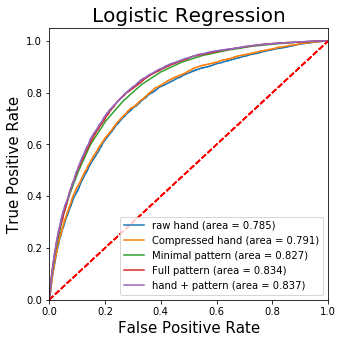

In [1502]:
plt.figure(figsize=(5,5))
plot_data(stupidhand,'raw hand',testX_sh,testy_sh)
plot_data(ch,'Compressed hand',testX_ch,testy_ch)
plot_data(ult,'Minimal pattern',testX_ult,testy_ult)
plot_data(fv,'Full pattern',testX_fv,testy_fv)
plot_data(chpfv,'hand + pattern',testX_chpfv,testy_chpfv, 'Logistic Regression')

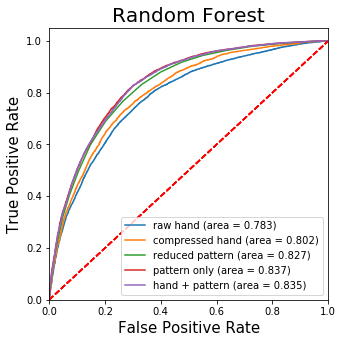

In [1471]:
plt.figure(figsize=(5,5))
plot_data(rf_sh,'raw hand',testX_sh,testy_sh)
plot_data(rf_ch,'compressed hand',testX_ch,testy_ch)
plot_data(rf_ult,'reduced pattern',testX_ult,testy_ult)
plot_data(rf_fv,'pattern only',testX_fv,testy_fv)
plot_data(rf_chpfv,'hand + pattern',testX_chpfv,testy_chpfv, 'Random Forest')

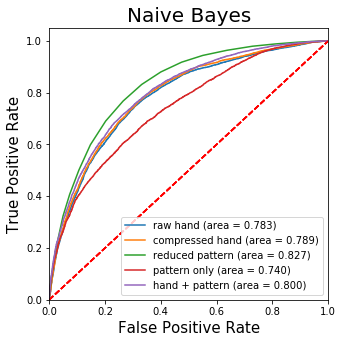

In [1489]:
plt.figure(figsize=(5,5))
plot_data(mnb1,'raw hand',testX_sh,testy_sh)
plot_data(mnb2,'compressed hand',testX_ch,testy_ch)
plot_data(mnb4,'reduced pattern',testX_ult,testy_ult)
plot_data(mnb3,'pattern only',testX_fv,testy_fv)
plot_data(mnb5,'hand + pattern',testX_chpfv,testy_chpfv, 'Naive Bayes')

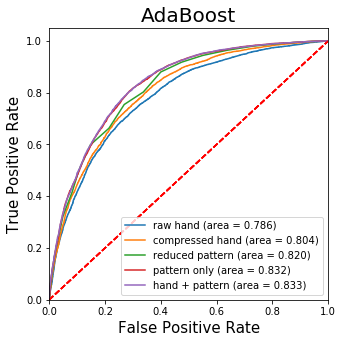

In [1490]:
plt.figure(figsize=(5,5))
plot_data(bdt1,'raw hand',testX_sh,testy_sh)
plot_data(bdt2,'compressed hand',testX_ch,testy_ch)
plot_data(bdt4,'reduced pattern',testX_ult,testy_ult)
plot_data(bdt3,'pattern only',testX_fv,testy_fv)
plot_data(bdt5,'hand + pattern',testX_chpfv,testy_chpfv, 'AdaBoost')

In [1901]:
ult.predict_proba(np.array([1,7]).reshape(1,-1))

array([[0.46064575, 0.53935425]])

# Model probability
## With a simple model of grand tichu win rate
Simulate random hands. See what each winrate in grand tichu correspond to in tichu.

For Tichu hand, we can call Tichu only when the winrate is > 50%. Therefore, with this we can find the right time to call grand tichu. 


## First, create our tichu and grand tichu winrate model

For grand Tichu, use our simplified feature vector

In [1964]:
[train_ind, test_ind] = train_test_split(range(len(gdata.made)),random_state=0)
allX = gdata.ultimate
ally = gdata.made
trainX = allX[train_ind]
trainy = gdata.made[train_ind]
testX = allX[test_ind]
testy = gdata.made[test_ind]

lr = LogisticRegression(random_state=0, solver='liblinear', \
                        multi_class='ovr')
lr.fit(allX, ally)
lr.coef_[0]

array([-0.13386249,  0.15598251])

[-0.1370524  0.1568176]


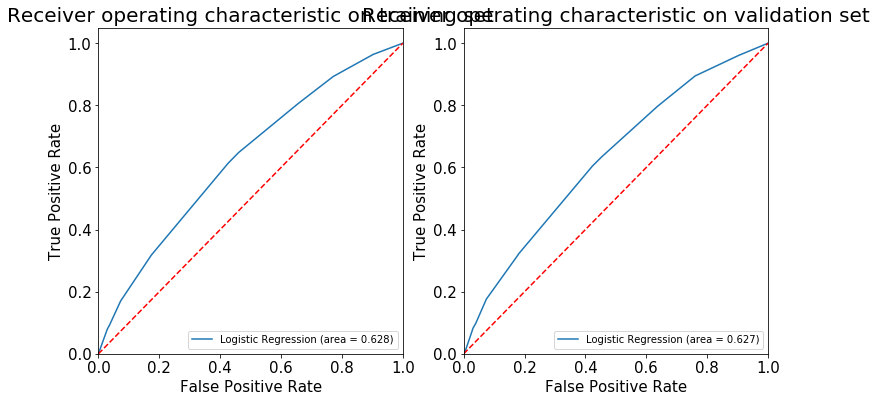

In [1965]:
lr.fit(trainX, trainy)
print(lr.coef_[0])
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_training(lr,'Logistic Regression')
plt.subplot(1,2,2)
plot_model(lr,'Logistic Regression')

In [1966]:
# dang, class_weight = 'balanced' messes up the prediction probability... 
grandlr = LogisticRegression(random_state=0, solver='liblinear', \
                        multi_class='ovr')
grandlr.fit(allX, ally)
print(lr.coef_[0])

[-0.1370524  0.1568176]


#### For Tichu, use our best performing algorithm (feature plus cards)

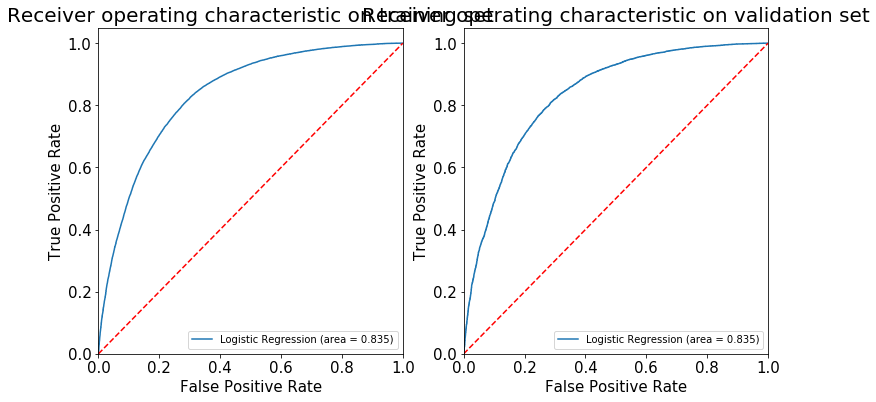

In [1967]:
[train_ind, test_ind] = train_test_split(range(len(tichudata.made)),random_state=2)
allX = tichudata.fv_plus_compress_hand
ally = tichudata.made

trainX = allX[train_ind]
trainy = tichudata.made[train_ind]
testX = allX[test_ind]
testy = tichudata.made[test_ind]
lr = LogisticRegression(random_state=0, solver='liblinear', \
                        multi_class='ovr')
lr.fit(trainX, trainy)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_training(lr,'Logistic Regression')
plt.subplot(1,2,2)
plot_model(lr,'Logistic Regression')

In [1968]:
tichulr = LogisticRegression(random_state=0, solver='liblinear', \
                        multi_class='ovr')
tichulr.fit(allX, ally);

# Simulate hand and winning prob
## grandlr for Grand
## tichulr for tichu

In [856]:
from util import *

In [1960]:
class simulate_hand():
    def __init__(self,n=1000,pick=[]):
        self.sim_grand_hand()
        if pick == []:
            self.sim_grand_hand()
        else:
            while self.ghd.ultimate[1] != pick:
                self.sim_grand_hand()
        
        # simulate tichu 
        self.tichuwinrate = np.zeros(n)
        for i in range(n):
            self.tichuwinrate[i] = self.sim_tichu_hand_new()
        self.compute_tichu_equivalent_winrate()
            
    def sim_grand_hand(self):           
        perm = np.random.permutation(56)
        self.cards8 = np.zeros(56)
        self.cards8[perm[:8]] = 1
        # grand hand
        self.ghd = handDataGrand(self.cards8)
        self.grandwinrate = grandlr.predict_proba(self.ghd.ultimate.reshape(1,-1))[0,1]
        
    def sim_tichu_hand(self):
        othercards = np.where(self.cards8 == 0)[0]
        perm = np.random.permutation(othercards)
        # remove dog
        if self.cards8[53] == 1:
            self.allcards = copy.deepcopy(self.cards8)
            self.allcards[53] = 0
            self.allcards[perm[:7]] = 1
        else:
            self.allcards = copy.deepcopy(self.cards8)
            self.allcards[perm[:6]] = 1
        # tichu hand
        self.thd = handData(self.allcards)
        return tichulr.predict_proba(self.thd.fv_plus_compress_hand.reshape(1,-1))[0,1]
    
    def sim_tichu_hand_new(self):
        # initiate hand
        self.allcards = copy.deepcopy(self.cards8)
        othercards = np.where(self.cards8 == 0)[0]
        # teammate gives you the best card
        perm = np.random.permutation(othercards)
        teammatehv = np.zeros(56)
        teammatehv[perm[:14]] = 1
        card = self.find_largest_card(self.vec2hand(teammatehv))
        cardind = np.where(self.hand2vec(card))[0]
        self.allcards[cardind] = 1
        # remove dog
        if self.cards8[53] == 1:
            self.allcards[53] = 0
            self.allcards[perm[14:21]] = 1
        else:
            self.allcards[perm[14:20]] = 1
        # tichu hand
        self.thd = handData(self.allcards)
        return tichulr.predict_proba(self.thd.fv_plus_compress_hand.reshape(1,-1))[0,1]    
    
    def find_largest_card(self, hand):
        # phoenix
        if {'Shape':7, 'Value':0} in hand:
            return [{'Shape':7, 'Value':0}]
        elif {'Shape':6, 'Value':0} in hand:
            return [{'Shape':6, 'Value':0}]
        else:
            shapelist = np.zeros(len(hand),int)
            valuelist = np.zeros(len(hand),int)
            for i,h in enumerate(hand):
                shapelist[i] = h['Shape']
                valuelist[i] = h['Value']
            ind = np.argmax(valuelist)
            return [{'Shape':shapelist[ind], 'Value':valuelist[ind]}]
    
    def compute_tichu_equivalent_winrate(self):
        temp = copy.deepcopy(self.tichuwinrate)
        temp[temp < 0.5] = 0.5
        self.equiv_win_rate = np.mean(temp)
        
    def hand2vec(self, handlist):
        """handlist is a list of dictionary, each dict has dict['Shape'] and dict['Value']
        dict['Shape']:
            Spades = 0,
            Hearts = 1,
            Diamond = 2,
            Clubs = 3,
            MahJong = 4,
            Dogs = 5,
            Dragon = 6,
            Phoinex = 7
        dict['Value']: card number (2-14). 14 for Ace. 0 for Dogs, Dragon, Phoinex. MahJong has value = 1
        """
        handvec = np.zeros(56)
        for card in handlist:
            # If card is a regular card
            if card['Shape'] in range(0,4):
                ind = card['Shape']*13+card['Value']-2
            else:
                ind = 52 + card['Shape'] - 4
            handvec[ind] = 1
        return handvec
    
    def vec2hand(self, handvec):
        """The reverse function from handvec into handlist. """
        handlist = []
        for ind, b in enumerate(handvec):
            card={}
            if b:
                if ind < 52:
                    card['Shape'] = ind//13
                    card['Value'] = ind%13 +2
                elif ind==52:
                    card['Shape'] = 4
                    card['Value'] = 1
                else:
                    card['Shape'] = ind - 52 +4
                    card['Value'] = 0
                handlist.append(card)
        return handlist

In [1961]:
select = gdata.ultimate[:,1]==4
sum(gdata.made[select])/float(sum(select))

0.6018654884634266

0.6951171095565685


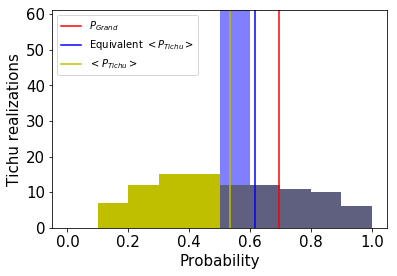

In [2001]:
test = simulate_hand(100,pick=7)
print test.grandwinrate
plt.hist(test.tichuwinrate,range = [0,1],bins=10,color='y')
temp = copy.deepcopy(test.tichuwinrate)
temp[temp<0.5] = 0.5
histo=plt.hist(temp,range = [0,1],bins=10,alpha=0.5,color='b')
plt.plot([test.grandwinrate, test.grandwinrate],[0,1000],color='r',label='$P_{Grand}$')
plt.plot([test.equiv_win_rate, test.equiv_win_rate],[0,1000],color='b',label='Equivalent $<P_{Tichu}>$')
plt.plot([np.mean(test.tichuwinrate), np.mean(test.tichuwinrate)],[0,1000],color='y',label='$<P_{Tichu}>$')
plt.ylim([0. ,np.max(histo[0])])
plt.xlabel('Probability')
plt.ylabel('Tichu realizations')
plt.legend()

In [1891]:
class runsim():
    def __init__(self, nsims):
        self.gwinrate = np.zeros(nsims)
        self.t_winrate = np.zeros(nsims)
        self.t_equiv_winrate = np.zeros(nsims)
        self.ultimate = np.zeros(nsims)
    

In [1376]:
# Simulate in particular for index = 8 (require bomb)
nsims = 100
bomb = runsim(nsims)
for i in range(nsims):
    print(i)
    sim = simulate_hand(1000)
    bomb.gwinrate[i] = sim.grandwinrate
    bomb.t_winrate[i] = np.mean(sim.tichuwinrate)
    bomb.t_equiv_winrate[i] = sim.equiv_win_rate
    bomb.ultimate[i] = sim.ghd.ultimate[1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [1948]:
# a bunch of simulations with small tichu realizations
nsims=1000
regsim = runsim(nsims)
for i in range(nsims):
    if i%100 == 0:
        print i
    sim = simulate_hand(100)
    regsim.gwinrate[i] = sim.grandwinrate
    regsim.t_winrate[i] = np.mean(sim.tichuwinrate)
    regsim.t_equiv_winrate[i] = sim.equiv_win_rate
    regsim.ultimate[i] = sim.ghd.ultimate[1]

0
100
200
300
400
500
600
700
800
900


In [1969]:
index = [0,2,4,5,6,7,9]
gwin = np.zeros_like(index,float)
twin = np.zeros_like(index,float)
tstd = np.zeros_like(index,float)
for i,ind in enumerate(index):
    select = regsim.ultimate == ind
    print i, ind, sum(select)
    gwin[i] = regsim.gwinrate[select][0]
    twin[i] = np.mean(regsim.t_equiv_winrate[select])
    tstd[i] = np.std(regsim.t_equiv_winrate[select])
    if ind==8:
        select = bomb.ultimate == ind
        print i, ind, sum(select)
        gwin[i] = bomb.gwinrate[select][0]
        twin[i] = np.mean(bomb.t_equiv_winrate[select])
        tstd[i] = np.std(bomb.t_equiv_winrate[select])
        


0 0 349
1 2 288
2 4 74
3 5 152
4 6 11
5 7 87
6 9 17


In [1970]:
plt.rcParams.update({'font.size': 10})
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

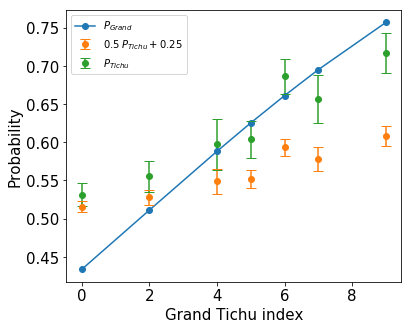

In [1971]:
plt.figure(figsize=(6,5))
plt.plot(index, gwin,'o-',label='$P_{Grand}$')
plt.errorbar(index, 0.25+0.5*twin, 0.5*tstd,fmt='o',capsize=5,label='$0.5\;P_{Tichu}+0.25$')
plt.errorbar(index, twin, tstd,fmt='o',capsize=5,label='$P_{Tichu}$')
plt.xlabel('Grand Tichu index')
plt.ylabel('Probability')
plt.legend()
plt.savefig('plots/g_t_success_rate.png')

grand winrate 0.5741732909583946
threshold tichu winrate 0.6483465819167893
mean tichu prob 0.6679326077738176
mean tichu std 0.0030203962810863992


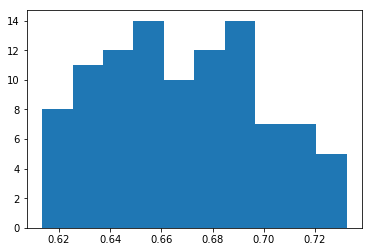

In [1514]:
select = bomb.ultimate == 8
n = sum(select)
gwin = bomb.gwinrate[select][0]
print 'grand winrate', bomb.gwinrate[select][0]
print 'threshold tichu winrate',2*gwin-0.5
print 'mean tichu prob', np.mean(bomb.t_equiv_winrate[select])
plt.hist(bomb.t_equiv_winrate[select]);
print 'mean tichu std', np.std(bomb.t_equiv_winrate[select])/np.sqrt(n)

In [1864]:
test = tichulr.predict_proba(tichudata.fv_plus_compress_hand)
np.mean(test[:,1])

0.42986038232862905

In [1861]:
test = grandlr.predict_proba(gdata.ultimate)
np.mean(test[:,1])

0.6639671188025532

(array([1.174e+03, 0.000e+00, 1.870e+03, 0.000e+00, 2.037e+03, 3.475e+03,
        0.000e+00, 6.900e+02, 5.714e+03, 1.000e+01, 2.678e+03, 1.309e+03,
        2.340e+02, 0.000e+00, 1.063e+03, 1.000e+00, 2.070e+02, 0.000e+00,
        1.500e+01, 7.000e+00]),
 array([ 0.  ,  0.85,  1.7 ,  2.55,  3.4 ,  4.25,  5.1 ,  5.95,  6.8 ,
         7.65,  8.5 ,  9.35, 10.2 , 11.05, 11.9 , 12.75, 13.6 , 14.45,
        15.3 , 16.15, 17.  ]),
 <a list of 20 Patch objects>)

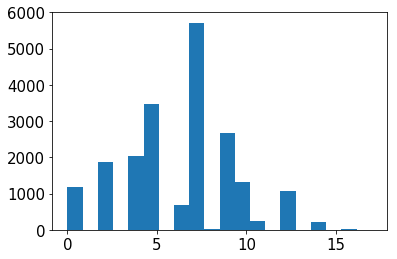

In [1742]:
plt.hist(gdata.ultimate[:,1],bins=20)

In [1775]:
select  = np.where((gdata.ultimate[:,1] == 4) & gdata.made)[0]
tichudata.vec2hand(gdata.cards8[select[9]])

[{'Shape': 1, 'Value': 14},
 {'Shape': 2, 'Value': 4},
 {'Shape': 2, 'Value': 5},
 {'Shape': 2, 'Value': 8},
 {'Shape': 2, 'Value': 11},
 {'Shape': 2, 'Value': 14},
 {'Shape': 3, 'Value': 10},
 {'Shape': 3, 'Value': 12}]

In [1726]:
sum(gdata.made)/float(len(gdata.made))

0.6639328256199961

In [1743]:
grandlr.predict_proba(np.array([1,0]).reshape(1,-1))

array([[0.56653431, 0.43346569]])

In [1676]:
print 'averaged grand tichu make prob:', np.mean(regsim.gwinrate[regsim.gwinrate > 0.5])

averaged grand tichu make prob: 0.5689492455496096


[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 6}]
[{'Shape': 0, 'Value': 5}]
[{'Shape': 0, 'Value': 7}]
[{'Shape': 0, 'Value': 8}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 5}]
[{'Shape': 0, 'Value': 6}]
[{'Shape': 0, 'Value': 9}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 10}]
[{'Shape': 0, 'Value': 5}]
[{'Shape': 0, 'Value': 11}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 9}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 6}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 10}]
[{'Shape': 0, 'Value': 9}]
[{'Shape': 0, 'Value': 5}]
[{'Shape': 0, 'Value': 9}]
[{'Shape': 1, 'Value': 3}]
[{'Shape': 0, 'Value': 7}]
[{'Shape': 0, 'Value': 7}]
[{'Shape': 0, 'Value': 5}

[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 5}]
[{'Shape': 0, 'Value': 6}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 5}]
[{'Shape': 0, 'Value': 6}]
[{'Shape': 0, 'Value': 6}]
[{'Shape': 0, 'Value': 9}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 6}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 9}]
[{'Shape': 0, 'Value': 7}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 8}]
[{'Shape': 0, 'Value': 7}]
[{'Shape': 0, 'Value': 9}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 5}]
[{'Shape': 0, 'Value': 6}]
[{'Shape': 0, 'Value': 10}]
[{'Shape': 0, 'Value': 5}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 5}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 5}]


[{'Shape': 0, 'Value': 5}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 8}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 7}]
[{'Shape': 0, 'Value': 7}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 10}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 11}]
[{'Shape': 0, 'Value': 8}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 7}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 9}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 12}]
[{'Shape': 0, 'Value': 4}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 6}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 5}]
[{'Shape': 0, 'Value': 2}]
[{'Shape': 0, 'Value': 6}]
[{'Shape': 0, 'Value': 5}]
[{'Shape': 0, 'Value': 5}

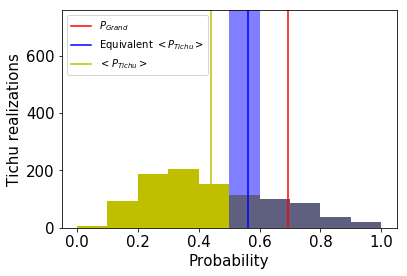

In [1799]:
test = simulate_hand(1000,pick=7)
plt.hist(test.tichuwinrate,range = [0,1],bins=10,color='y')
temp = copy.deepcopy(test.tichuwinrate)
temp[temp<0.5] = 0.5
histo=plt.hist(temp,range = [0,1],bins=10,alpha=0.5,color='b')
plt.plot([test.grandwinrate, test.grandwinrate],[0,1000],color='r',label='$P_{Grand}$')
plt.plot([test.equiv_win_rate, test.equiv_win_rate],[0,1000],color='b',label='Equivalent $<P_{Tichu}>$')
plt.plot([np.mean(test.tichuwinrate), np.mean(test.tichuwinrate)],[0,1000],color='y',label='$<P_{Tichu}>$')
plt.ylim([0. ,np.max(histo[0])])
plt.xlabel('Probability')
plt.ylabel('Tichu realizations')
plt.legend()

grand winrate 0.49681970272734316
threshold tichu winrate 0.4936394054546863
mean tichu prob 0.5967910905532299
mean tichu std 0.003939300668591745


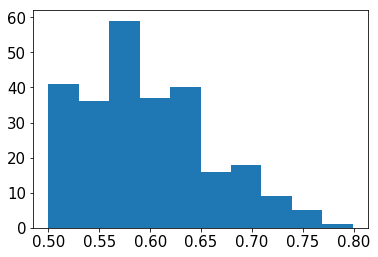

In [1647]:
select = regsim.ultimate == 6
n = sum(select)
gwin = regsim.gwinrate[select][0]
print 'grand winrate', regsim.gwinrate[select][0]
print 'threshold tichu winrate',2*gwin-0.5
print 'mean tichu prob', np.mean(regsim.t_equiv_winrate[select])
plt.hist(regsim.t_equiv_winrate[select]);
print 'mean tichu std', np.std(regsim.t_equiv_winrate[select])/np.sqrt(n)

In [1548]:
index = range(6,12)
gwin = np.zeros_like(index,float)
twin = np.zeros_like(index,float)
tstd = np.zeros_like(index,float)
for i,ind in enumerate(index):
    select = regsim.ultimate == ind
    print i, ind, sum(select)
    gwin[i] = regsim.gwinrate[select][0]
    twin[i] = np.mean(regsim.t_equiv_winrate[select])
    tstd[i] = np.std(regsim.t_equiv_winrate[select])
    if ind==8:
        select = bomb.ultimate == ind
        print i, ind, sum(select)
        gwin[i] = bomb.gwinrate[select][0]
        twin[i] = np.mean(bomb.t_equiv_winrate[select])
        tstd[i] = np.std(bomb.t_equiv_winrate[select])
        

    

0 6 262
1 7 3227
2 8 2
2 8 100
3 9 688
4 10 396
5 11 45


[1 6]
0.49681970272734316
0.4534269966075345
0.5873898895528495


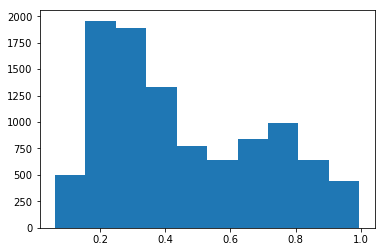

In [1297]:
test = simulate_hand(10000)
print(test.ghd.ultimate)
print(test.grandwinrate)
plt.hist(test.tichuwinrate)
print(np.mean(test.tichuwinrate))
print(test.equiv_win_rate)

In [1233]:
test.vec2hand(test.cards8)

[{'Shape': 0, 'Value': 7},
 {'Shape': 1, 'Value': 3},
 {'Shape': 1, 'Value': 12},
 {'Shape': 1, 'Value': 14},
 {'Shape': 3, 'Value': 4},
 {'Shape': 3, 'Value': 14},
 {'Shape': 5, 'Value': 0},
 {'Shape': 6, 'Value': 0}]

0.6857647279725194

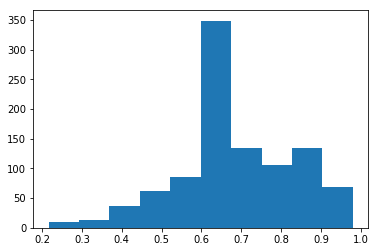

In [1089]:
plt.hist(test.tichuwinrate)
np.mean(test.tichuwinrate)

# Ultimate index for Tichu prediction

array([-0.78784487,  0.28822462])

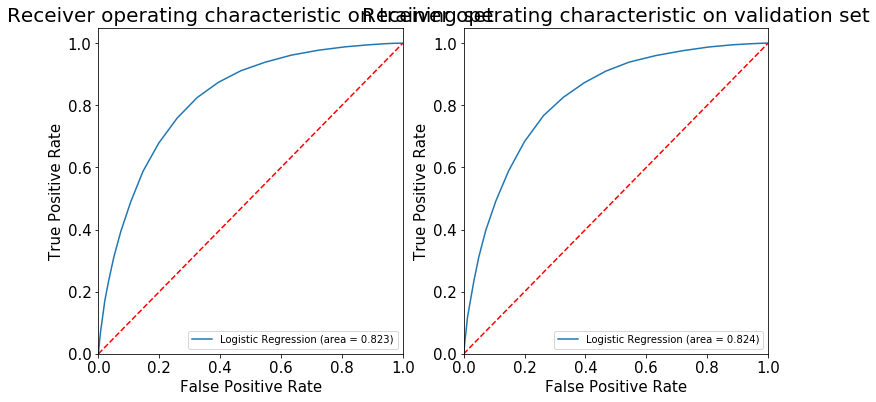

In [1973]:
[train_ind, test_ind] = train_test_split(range(len(tichudata.made)),random_state=2)
allX = tichudata.ultimate
ally = tichudata.made

trainX = allX[train_ind]
trainy = tichudata.made[train_ind]
testX = allX[test_ind]
testy = tichudata.made[test_ind]
lr = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', \
                        multi_class='ovr')
lr.fit(trainX, trainy)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_training(lr,'Logistic Regression')
plt.subplot(1,2,2)
plot_model(lr,'Logistic Regression')
lr.coef_[0]

In [1976]:
lr = LogisticRegression(random_state=0, solver='liblinear',  \
                        multi_class='ovr')
lr.fit(allX, ally);

In [1977]:
lr.coef_[0]

array([-0.91985654,  0.28484669])

In [1981]:
lr.predict_proba(np.array([1, 6.5]).reshape(1,-1))

array([[0.49705243, 0.50294757]])

In [1979]:
selectfeature = [0,1,2,3,4,9,12]
w = np.array([2,-2,6,6,5,1,-1],float)
np.transpose([np.array(tichudata.feature_explanation)[selectfeature], w])

array([['self.ace', '2.0'],
       ['self.dog', '-2.0'],
       ['self.dragon', '6.0'],
       ['self.phoenix', '6.0'],
       ['self.num_of_bombs', '5.0'],
       ['self.longest_straight_length', '1.0'],
       ['self.num_small_card', '-1.0']], dtype='|S32')

In [1993]:
len(matches)

14765

In [1985]:
np.sum([len(m['Rounds']) for m in matches])

84127

In [1992]:
len(gdata.made)

20484

In [1990]:
test = tichuData()
test.loaddata(matches)

In [1991]:
len(test.made)

38057

# Permute suits

In [338]:
tichudata.vec2hand(tichudata.allcards[0])

[{'Shape': 0, 'Value': 2},
 {'Shape': 0, 'Value': 3},
 {'Shape': 0, 'Value': 14},
 {'Shape': 1, 'Value': 3},
 {'Shape': 1, 'Value': 6},
 {'Shape': 1, 'Value': 13},
 {'Shape': 2, 'Value': 2},
 {'Shape': 2, 'Value': 5},
 {'Shape': 2, 'Value': 9},
 {'Shape': 2, 'Value': 13},
 {'Shape': 3, 'Value': 3},
 {'Shape': 3, 'Value': 4},
 {'Shape': 3, 'Value': 7},
 {'Shape': 3, 'Value': 8}]

In [1972]:
tichudata.feature_explanation

['self.ace',
 'self.dog',
 'self.dragon',
 'self.phoenix',
 'self.num_of_bombs',
 'self.num_of_threes',
 'self.largest_three',
 'self.num_of_pairs',
 'self.largest_pair',
 'self.longest_straight_length',
 'self.largest_straight',
 'self.num_of_tractors',
 'self.num_small_card']

In [877]:
np.random.permutation(range(10))[:5]

array([0, 2, 5, 6, 9])

In [71]:
for i in range(len(data.made)):
    testhand = data.vec2hand(data.allcards[i,:])
    hd = handData(testhand)
    hd.find_bombs()
    if hd.num_of_bumb>0:
        print(hd.num_of_bumb)
        print(hd.fours)
        print(hd.sf_range)
        print('\n')

1
[9]
[]


1
[]
[4 9]


1
[]
[ 6 11]


1
[6]
[]


1
[6]
[]


1
[3]
[]


1
[2]
[]


1
[]
[ 6 11]


1
[3]
[]


1
[11]
[]


1
[]
[10 15]


1
[12]
[]


1
[9]
[]


1
[5]
[]


1
[14]
[]


1
[]
[ 9 15]


1
[3]
[]


1
[2]
[]


1
[2]
[]


1
[8]
[]


1
[]
[4 9]


1
[11]
[]


1
[2]
[]


1
[]
[ 9 14]


1
[]
[ 9 15]


1
[5]
[]


1
[]
[3 8]


1
[8]
[]


1
[13]
[]


1
[2]
[]


1
[7]
[]


1
[10]
[]


1
[11]
[]


1
[6]
[]


1
[2]
[]


1
[2]
[]


1
[]
[2 7]


1
[]
[4 9]


1
[11]
[]


1
[]
[2 8]


1
[2]
[]


1
[]
[ 9 14]


1
[]
[2 8]


2
[ 3 14]
[]


1
[10]
[]


1
[14]
[]


1
[2]
[]


1
[9]
[]


2
[ 3 11]
[]


1
[]
[2 7]


1
[13]
[]


1
[]
[ 6 12]


1
[13]
[]


1
[]
[ 3 10]


1
[2]
[]


1
[2]
[]


1
[14]
[]


1
[11]
[]


1
[]
[ 7 13]


1
[4]
[]


1
[14]
[]


1
[]
[ 8 13]


1
[13]
[]


1
[]
[ 7 12]


1
[2]
[]


1
[14]
[]


1
[]
[2 7]


1
[7]
[]


1
[5]
[]


1
[14]
[]


1
[13]
[]


1
[2]
[]


1
[11]
[]


1
[13]
[]


1
[]
[ 6 11]


1
[8]
[]


1
[8]
[]


1
[14]
[]


1
[11]
[]


1
[14]
[]


2
[10]
[3 8]


1
[

[]


1
[2]
[]


1
[]
[ 7 12]


1
[]
[ 5 12]


1
[14]
[]


1
[6]
[]


1
[]
[3 8]


1
[9]
[]


1
[2]
[]


1
[]
[10 15]


1
[5]
[]


1
[]
[ 6 11]


1
[7]
[]


1
[4]
[]


1
[11]
[]


1
[]
[3 8]


1
[7]
[]


2
[2]
[10 15]


1
[14]
[]


1
[3]
[]


1
[4]
[]


1
[4]
[]


1
[6]
[]


1
[]
[2 8]


1
[]
[10 15]


1
[14]
[]


1
[5]
[]


1
[]
[3 8]


1
[3]
[]


2
[3 5]
[]


1
[]
[ 5 11]


1
[6]
[]


2
[4 8]
[]


1
[11]
[]


1
[5]
[]


1
[3]
[]


1
[14]
[]


1
[7]
[]


1
[11]
[]


2
[ 7 10]
[]


1
[]
[2 8]


1
[]
[3 8]


1
[6]
[]


1
[12]
[]


1
[12]
[]


1
[]
[ 5 10]


1
[8]
[]


1
[]
[ 7 13]


1
[2]
[]


1
[14]
[]


1
[2]
[]


1
[10]
[]


1
[5]
[]


1
[]
[ 6 11]


1
[]
[ 8 13]


1
[8]
[]


1
[]
[3 9]


1
[2]
[]


1
[]
[3 8]


1
[5]
[]


1
[4]
[]


1
[]
[10 15]


1
[4]
[]


1
[13]
[]


1
[5]
[]


1
[]
[ 5 10]


1
[3]
[]


1
[4]
[]


1
[]
[ 5 10]


1
[]
[ 7 12]


1
[8]
[]


1
[8]
[]


1
[]
[3 8]


1
[14]
[]


1
[14]
[]


1
[3]
[]


1
[]
[10 15]


1
[8]
[]


2
[ 3 13]
[]


1
[11]
[]


1
[13]
[]


1
[1

1
[5]
[]


1
[10]
[]


2
[6]
[4 9]


1
[]
[10 15]


1
[3]
[]


1
[9]
[]


2
[4]
[2 7]


1
[]
[ 8 14]


1
[12]
[]


1
[11]
[]


1
[11]
[]


1
[13]
[]


1
[12]
[]


1
[12]
[]


2
[11 13]
[]


1
[3]
[]


1
[]
[4 9]


1
[12]
[]


2
[2 9]
[]


1
[]
[ 7 12]


1
[4]
[]


1
[3]
[]


1
[14]
[]


1
[5]
[]


1
[]
[2 7]


1
[10]
[]


1
[14]
[]


2
[8]
[ 5 10]


1
[4]
[]


1
[2]
[]


1
[14]
[]


1
[]
[ 8 14]


2
[12]
[ 9 15]


2
[4 7]
[]


1
[7]
[]


1
[]
[4 9]


1
[]
[ 7 12]


1
[2]
[]


1
[10]
[]


1
[10]
[]


1
[]
[ 4 10]


2
[6]
[ 5 11]


1
[8]
[]


1
[14]
[]


1
[2]
[]


1
[6]
[]


2
[2 7]
[]


1
[8]
[]


1
[]
[2 7]


1
[8]
[]


1
[8]
[]


2
[5 6]
[]


1
[2]
[]


1
[3]
[]


2
[ 4 11]
[]


1
[8]
[]


1
[14]
[]


1
[2]
[]


1
[13]
[]


1
[]
[ 7 12]


1
[]
[ 9 14]


1
[]
[10 15]


1
[2]
[]


1
[]
[ 5 11]


1
[]
[2 9]


2
[2 3]
[]


1
[9]
[]


1
[5]
[]


1
[13]
[]


1
[]
[ 4 10]


1
[5]
[]


1
[4]
[]


1
[6]
[]


1
[13]
[]


1
[10]
[]


1
[11]
[]


1
[]
[ 9 14]


1
[12]
[]


1
[6]
[]


1
[13]
[]



1
[3]
[]


1
[3]
[]


1
[6]
[]


1
[]
[4 9]


1
[3]
[]


1
[2]
[]


1
[8]
[]


1
[7]
[]


1
[4]
[]


1
[13]
[]


1
[]
[ 5 10]


1
[2]
[]


1
[3]
[]


1
[9]
[]


1
[11]
[]


1
[11]
[]


1
[14]
[]


1
[]
[3 8]


1
[4]
[]


1
[2]
[]


2
[6]
[10 15]


1
[4]
[]


1
[14]
[]


1
[]
[4 9]


1
[]
[ 9 14]


1
[11]
[]


1
[]
[ 7 12]


1
[14]
[]


1
[]
[2 7]


1
[4]
[]


1
[9]
[]


1
[]
[4 9]


1
[9]
[]


1
[3]
[]


1
[3]
[]


1
[7]
[]


1
[6]
[]


1
[]
[ 7 12]


1
[5]
[]


2
[4]
[ 9 14]


1
[10]
[]


1
[11]
[]


1
[]
[ 8 14]


1
[3]
[]


1
[]
[ 5 10]


1
[14]
[]


1
[3]
[]


1
[]
[ 7 12]


1
[8]
[]


1
[4]
[]


1
[]
[ 5 10]


1
[11]
[]


1
[12]
[]


1
[13]
[]


1
[12]
[]


1
[14]
[]


1
[11]
[]


1
[]
[ 5 10]


1
[13]
[]


1
[]
[ 6 14]


1
[]
[ 7 12]


1
[3]
[]


1
[]
[4 9]


1
[2]
[]


1
[]
[ 3 11]


1
[8]
[]


1
[10]
[]


1
[]
[ 5 10]


1
[3]
[]


1
[]
[3 8]


1
[2]
[]


1
[13]
[]


1
[6]
[]


1
[]
[ 3 10]


1
[]
[2 8]


1
[]
[ 7 12]


1
[10]
[]


1
[2]
[]


1
[3]
[]


1
[13]
[]


1
[11]
[]


1

[]
[10 15]


1
[3]
[]


1
[5]
[]


1
[9]
[]


1
[13]
[]


1
[4]
[]


1
[6]
[]


1
[2]
[]


1
[2]
[]


1
[3]
[]


1
[12]
[]


1
[]
[2 8]


1
[2]
[]


1
[]
[10 15]


1
[3]
[]


2
[3]
[ 8 13]


1
[2]
[]


1
[5]
[]


1
[14]
[]


1
[13]
[]


1
[]
[ 3 10]


1
[]
[2 7]


1
[12]
[]


1
[2]
[]


1
[6]
[]


1
[8]
[]


1
[2]
[]


1
[5]
[]


1
[2]
[]


1
[]
[ 5 11]


1
[]
[ 9 15]


1
[]
[ 7 12]


1
[9]
[]


1
[]
[10 15]


1
[12]
[]


2
[ 9 12]
[]


1
[9]
[]


1
[]
[ 6 11]


1
[9]
[]


1
[12]
[]


1
[3]
[]


1
[2]
[]


1
[]
[2 7]


1
[10]
[]


1
[10]
[]


1
[5]
[]


1
[9]
[]


1
[4]
[]


1
[]
[2 7]


1
[6]
[]


1
[11]
[]


1
[4]
[]


1
[]
[3 9]


1
[]
[10 15]


1
[3]
[]


1
[8]
[]


1
[12]
[]


2
[3 6]
[]


1
[5]
[]


1
[3]
[]


1
[14]
[]


1
[]
[ 5 11]


1
[]
[4 9]


1
[10]
[]


1
[9]
[]


1
[11]
[]


2
[3 4]
[]


1
[6]
[]


1
[4]
[]


1
[10]
[]


1
[2]
[]


1
[14]
[]


1
[5]
[]


1
[]
[ 6 11]


1
[]
[3 8]


1
[13]
[]


1
[6]
[]


1
[4]
[]


1
[]
[ 4 10]


1
[]
[ 4 11]


1
[13]
[]


1
[]
[ 3 10]



In [30]:
testhand

[{'Shape': 0, 'Value': 4},
 {'Shape': 0, 'Value': 14},
 {'Shape': 1, 'Value': 2},
 {'Shape': 1, 'Value': 3},
 {'Shape': 1, 'Value': 12},
 {'Shape': 2, 'Value': 2},
 {'Shape': 2, 'Value': 4},
 {'Shape': 2, 'Value': 10},
 {'Shape': 2, 'Value': 14},
 {'Shape': 3, 'Value': 4},
 {'Shape': 3, 'Value': 11},
 {'Shape': 3, 'Value': 12},
 {'Shape': 3, 'Value': 14},
 {'Shape': 4, 'Value': 1}]

In [42]:

regular_card_array = np.zeros([4,15]);
for c in testhand:
    if c['Shape'] in range(4):
        regular_card_array[c['Shape'], c['Value']] = 1
# detect flush
for suit in regular_card_array:
    # pad zeros in front and back
    padsuit = np.concatenate(([0], suit, [0]))
    absdiff = np.abs(np.diff(padsuit))
    ranges = np.where(absdiff == 1)[0].reshape(-1,2)
    length = np.array([r[1]-r[0] for r in  ranges])
        

In [41]:
ranges

array([[ 4,  5],
       [11, 13],
       [14, 15]])

In [43]:
length

array([2, 3, 2])